# [XAI(Explainable Artificial Intelligence)](https://iancovert.com/blog/understanding-shap-sage/)
> XAI는 설명 가능한 인공지능의 약자로, 인공지능의 행위와 도출한 결과를 사람이 이해할 수 있는 형태로 설명하는 방법론과 분야를 일컫는다.    
> 흔히 인공지능 기술은 복잡한 일련의 과정을 통해 결론을 도출하나, 그 과정을 설명할 수 없는 블랙박스로 여겨진다. XAI는 이에 반하는 개념으로 인공지능의 불확실성을 해소하고 신뢰성을 높이는 역할을 하여, 최근 연구가 활발하게 이루어지는 분야이다.

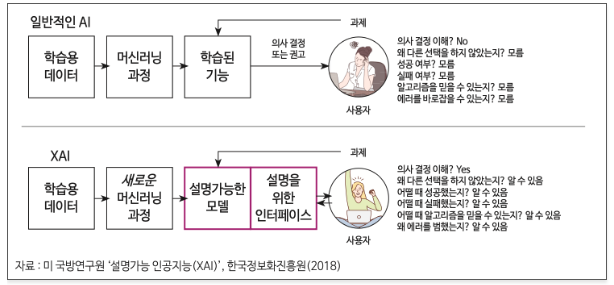

적용 사례

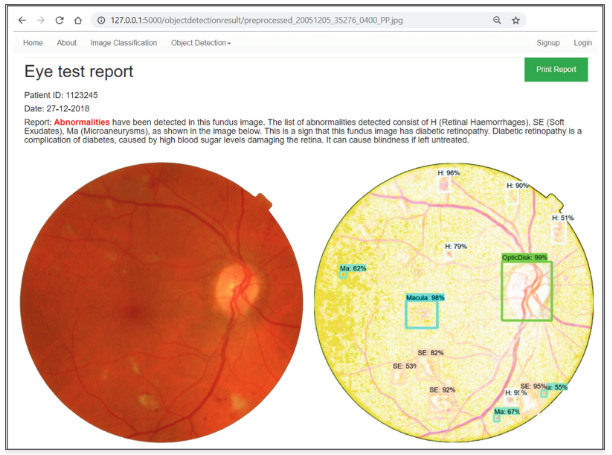

## SHAP vs SAGE

- SHAP
> how much does each feature contribute to this individual prediction?  
> 각 피쳐들이 개별 예측에 얼마나 기여를 하였는지?
- SAGE
> how much does the model depend on each feature overall?    
> 모델 학습시 각 피쳐들에 얼마나 의존하였는가?

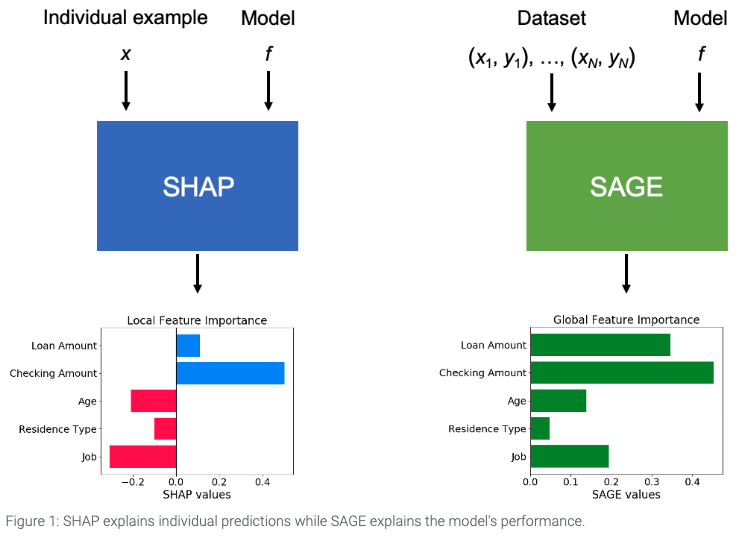

## 데이터 준비

데이터 로드

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns

df = sns.load_dataset('titanic') # 타이타닉 데이터 받아오기
cols = ["age","sibsp","parch","fare"] # 숫자니까 바로 사용
features = df[cols] # 피쳐
target = df["survived"] # 정답값

인코딩

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass","sex","embarked"] # 범주형

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp],axis=1)

In [ ]:
features.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan
0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


결측치 제거

In [ ]:
features.age = features.age.fillna(features.age.median())

데이터 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = pd.DataFrame(
    scaler.fit_transform(features),
    columns = features.columns
)

데이터 분리

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    random_state=random_state)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

## SAGE(Shapley Additive Global importancE)

학습

In [ ]:
from lightgbm import LGBMClassifier,plot_importance

model = LGBMClassifier(random_state = random_state).fit(X_tr,y_tr)

평가

In [ ]:
from sklearn.metrics import roc_auc_score

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8806949806949808

중요 파리미터 확인

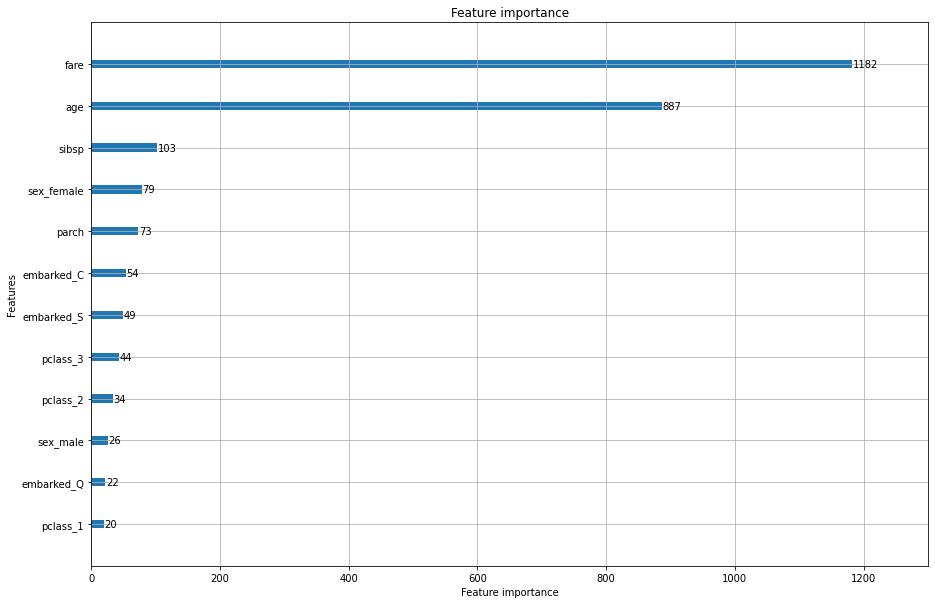

In [ ]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model,ax=ax)
plt.show()

## [SHAP(Shapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html)
- Shapley Value와 피쳐간 독립성을 핵심 아이디어로 사용하는 기법
- Shapley Value는 게임 이론을 바탕으로 각 피쳐의 기여도를 계산하는 방법
- SHAP의 목적은 예측에 대한 각 피쳐의 기여도를 계산하여 관측치(X) 의 예측값을 설명 하는것

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 5.7 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model) # 학습된 모델을 넣는다.
shap_values = explainer.shap_values(X_te)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
shap_values[1].shape , X_te.shape

((179, 13), (179, 13))

force_plot

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1][-1,:],X_te.iloc[-1,:])

summary_plot

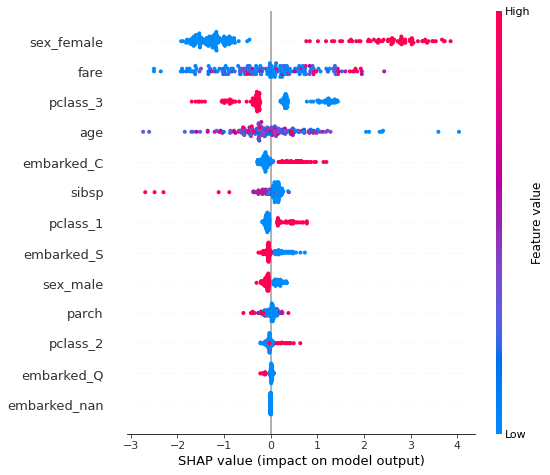

In [ ]:
shap.summary_plot(shap_values[1],X_te)

dependence_plot

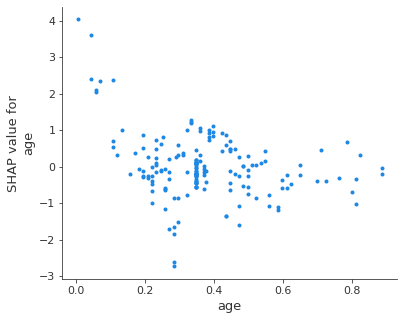

In [ ]:
shap.dependence_plot("age",shap_values[1],X_te,interaction_index=None)

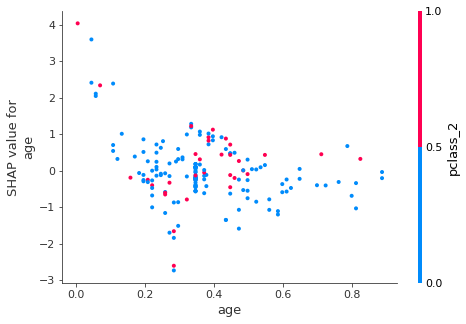

In [ ]:
shap.dependence_plot("age",shap_values[1],X_te,interaction_index="auto")

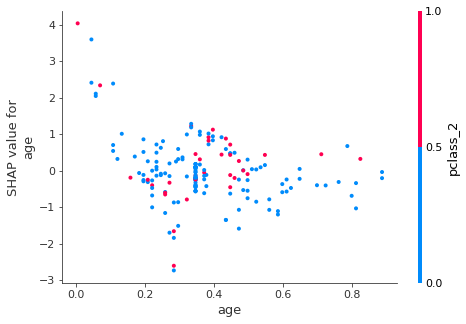

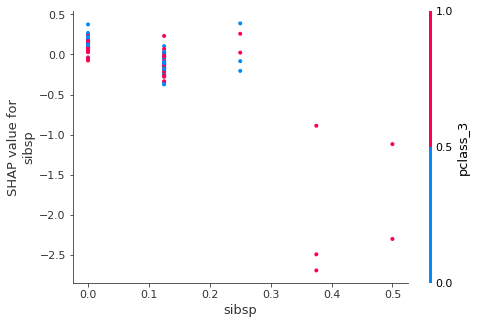

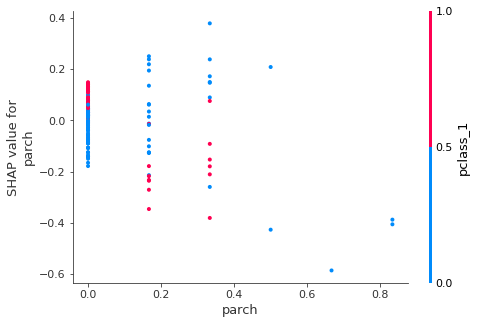

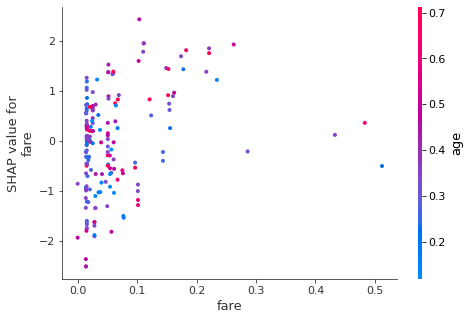

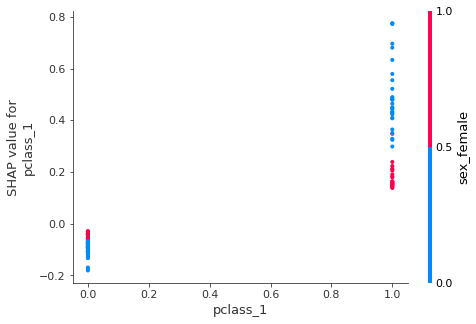

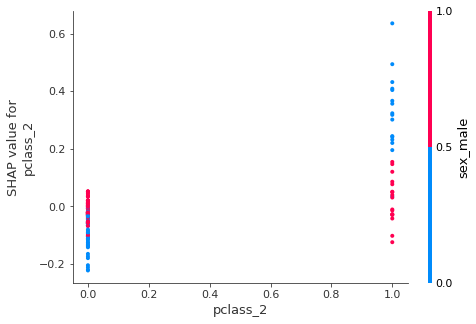

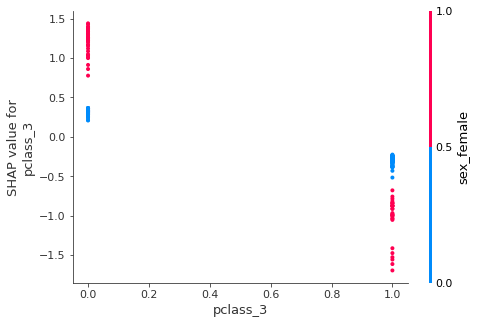

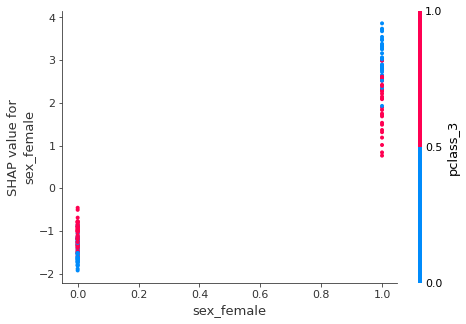

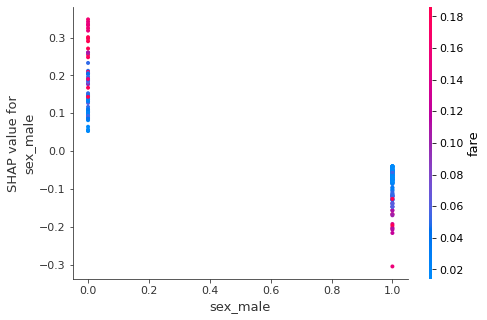

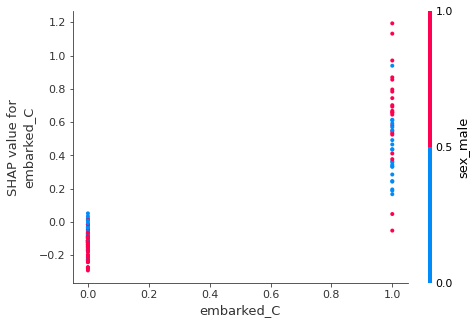

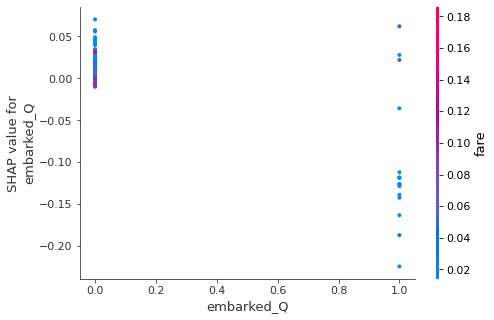

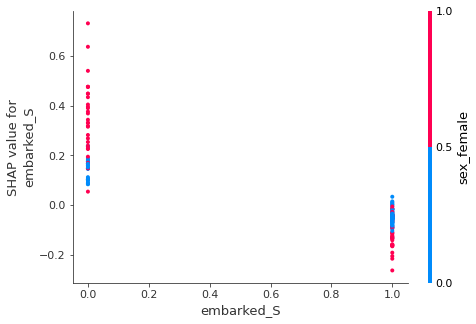

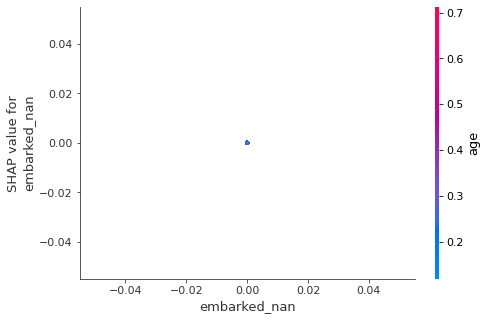

In [ ]:
for col in X_te.columns:
    shap.dependence_plot(col,shap_values[1],X_te)